#### The dataset columns

| Column name | Description |
| --- | --- |
| user_id | A unique number that identifies each player |
| version | group 30 - control group group 40 & group 50 test group | 
| sum_gamerounds | The number of game rounds played by the player during the first 14 days after install |
| retention1 | Did the player come back and play 1 day after installing |
| retention_7 | Did the player come back and play 7 days after installing |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
games = pd.read_csv("C:/Users/fajlh/OneDrive/Documents/ABtest/AB_test_git/cookie_cats.csv")

In [6]:
games.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


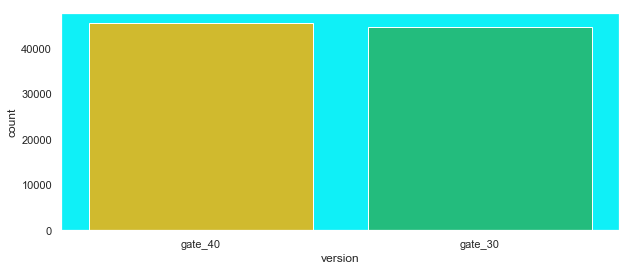

In [4]:
plt.figure(figsize=(10,4))
sns.set(rc={"axes.facecolor":"#0ff0f7", "axes.grid":False})
sns.countplot(x=games['version'] , order=games['version'].value_counts().index, palette=['#ebce13',"#09d681"])
plt.show()

In [5]:
games["retention_1"] = games["retention_1"].astype(int)
games["retention_7"] = games["retention_7"].astype(int)

#### Probability of retention

In [17]:
p30_1 = games[(games['version'] == 'gate_30') & (games['retention_1'] == 1)].shape[0]/games[games['version'] == 'gate_30'].shape[0]
print(p30_1)

0.4481879194630872


In [19]:
p30_7 = games[(games['version'] == 'gate_30') & (games['retention_7'] == 1)].shape[0]/games[games['version'] == 'gate_30'].shape[0]
print(p30_7)

0.19020134228187918


#### Normality assumption

In [21]:
games[games['version'] == 'gate_30'].shape[0] * (p30_1)

20034.0

#### Standard error of the mean

In [24]:
SE_30_1 = ((p30_1*(1-p30_1))/games[games['version'] == 'gate_30'].shape[0])**0.5
print(SE_30_1)

0.00235218736941068


In [26]:
SE_30_7 = ((p30_7*(1-p30_7))/games[games['version'] == 'gate_30'].shape[0])**0.5
print(SE_30_7)

0.001856271742020776


#### margin of error

In [29]:
m30_1 = 2.58 * SE_30_1
print(m30_1)

0.006068643413079554


In [30]:
m30_7 = 2.58*SE_30_7
print(m30_7)

0.004789181094413602


#### confidence interval for retention

In [38]:
# The number of retention in day 1 would be between 
# print((p30_1 - m30_1) * games[games['version'] == 'gate_30'].shape[0])
# print((p30_1 + m30_1) * games[games['version'] == 'gate_30'].shape[0])
print("The 99% Confidence Interval for the number of retention in day 1 for gate at level 30 would be between {} and {}".format((p30_1 - m30_1) * games[games['version'] == 'gate_30'].shape[0], (p30_1 + m30_1) * games[games['version'] == 'gate_30'].shape[0]))
print("The 99% Confidence Interval for the number of retention in day 7 for gate at level 30 would be between {} and {}".format((p30_7 - m30_7) * games[games['version'] == 'gate_30'].shape[0], (p30_7 + m30_7) * games[games['version'] == 'gate_30'].shape[0]))


The 99% Confidence Interval for the number of retention in day 1 for gate at level 30 would be between 19762.731639435344 and 20305.268360564656
The 99% Confidence Interval for the number of retention in day 7 for gate at level 30 would be between 8287.923605079712 and 8716.076394920286


In [18]:
p40_1 = games[(games['version'] == 'gate_40') & (games['retention_1'] == 1)].shape[0]/games[games['version'] == 'gate_40'].shape[0]
print(p40_1)

0.44228274967574577


In [20]:
p40_7 = games[(games['version'] == 'gate_40') & (games['retention_7'] == 1)].shape[0]/games[games['version'] == 'gate_40'].shape[0]
print(p40_7)

0.18200004396667327


In [25]:
SE_40_1 = ((p40_1*(1-p40_1))/games[games['version'] == 'gate_40'].shape[0])**0.5
print(SE_40_1)

0.0023286479953834732


In [27]:
SE_40_7 = ((p40_7*(1-p40_7))/games[games['version'] == 'gate_40'].shape[0])**0.5
print(SE_40_7)

0.0018090859125447062


In [31]:
m40_1 = 2.58*SE_40_1
print(m40_1)

0.006007911828089361


In [32]:
m40_7 = 2.58 * SE_40_7
print(m40_7)

0.004667441654365342


In [39]:
print("The 99% Confidence Interval for the number of retention in day 1 for gate at level 40 would be between {} and {}".format((p40_1 - m40_1) * games[games['version'] == 'gate_40'].shape[0], (p40_1 + m40_1) * games[games['version'] == 'gate_30'].shape[0]))
print("The 99% Confidence Interval for the number of retention in day 1 for gate at level 30 would be between {} and {}".format((p40_7 - m40_7) * games[games['version'] == 'gate_40'].shape[0], (p40_7 + m40_7) * games[games['version'] == 'gate_40'].shape[0]))


The 99% Confidence Interval for the number of retention in day 1 for gate at level 40 would be between 19845.706098852042 and 20038.59256922143
The 99% Confidence Interval for the number of retention in day 1 for gate at level 30 would be between 8066.682746584575 and 8491.317253415426
